# Segmentation of cells/nuclei (Setup)

This is a setup notebook for adjusting parameters for [run_roi_segmentation.ipynb](run_roi_segmentation.ipynb).

Run this notebook cell-by-cell and follow the instructions.

## Documentation

[Details of the cell/nuclei segmentation procedure](../docs/roi_segmentation.md)

[Table summarizing all parameters that are adjusted in this notebook](../docs/parameters.md#list-of-parameters-for-ROI-segmentation)

## Requirements

- A folder with images to segment

All z-layers and channels for a specific sample must be combined into a single file. To combine z-layers and channels, use the [setup_images_to_stack.ipynb](setup_images_to_stack.ipynb) and [run_images_to_stack.ipynb](run_images_to_stack.ipynb) notebooks.

The images must contain a channel with a fluorecent tag specific to the region of interest (ROI) to be segmented (cytoplasm or nuclei).

<hr style="height:2px;">

## Config

<hr style="height:2px;">

### The following code imports and declares functions used for the processing:

In [1]:
#################################
#  Don't modify the code below  #
#################################

import os
import json
import intake_io
import numpy as np
from skimage import io
import pylab as plt
from am_utils.utils import walk_dir
from punctatools.lib.segment import segment_roi
from punctatools.lib.utils import crop_dataset, show_dataset

2022-06-17 15:58:06,710 [INFO] WRITING LOG OUTPUT TO /home/amedyukh/.cellpose/run.log


### Please provide data paths:

`input_dir`: directory with images to be segmented

`output_dir`: directory to save the segmentation results; ROI masks will be added as an extra channel to the input image and saved in this directory

In [2]:
input_dir = "../example_data/stacks"
output_dir = "../test_output/roi"

### The following code lists all image files in the input directory:

In [3]:
#################################
#  Don't modify the code below  #
#################################

samples = walk_dir(input_dir)

print(f'\n{len(samples)} images were found:')
for i in range(len(samples)):
    print(i, samples[i])


2 images were found:
0 ../example_data/stacks/sample1_position1.tif
1 ../example_data/stacks/sample1_position2.tif


<hr style="height:0.5px;">

### Please provide the index of the sample to analyze:

Set to `None` to select a random image

In [4]:
sample_index = 0

### The following code loads a random image

In [5]:
#################################
#  Don't modify the code below  #
#################################
if sample_index is None:
    sample_index = np.random.randint(len(samples))
sample = samples[sample_index]
dataset = intake_io.imload(sample)
print(dataset, '\n')
if 'c' in dataset.dims:
    nchannels = len(dataset['c'].data)
    chnames = dataset['c'].data
else:
    nchannels = 1
    chnames = [0]
print(rf"Number of channels: {nchannels}")

<xarray.Dataset>
Dimensions:  (y: 326, x: 326, z: 5, c: 3)
Coordinates:
  * y        (y) float64 0.0 0.11 0.22 0.33 0.44 ... 35.42 35.53 35.64 35.75
  * x        (x) float64 0.0 0.11 0.22 0.33 0.44 ... 35.42 35.53 35.64 35.75
  * z        (z) float64 0.0 0.2 0.4 0.6 0.8
Dimensions without coordinates: c
Data variables:
    image    (c, z, y, x) uint16 105 106 103 110 106 113 ... 101 102 100 102 100
Attributes:
    metadata:  {'spacing_units': {'z': 'µm', 'y': 'µm', 'x': 'µm'}} 

Number of channels: 3


<hr style="height:0.5px;">

### The following code displays an example image

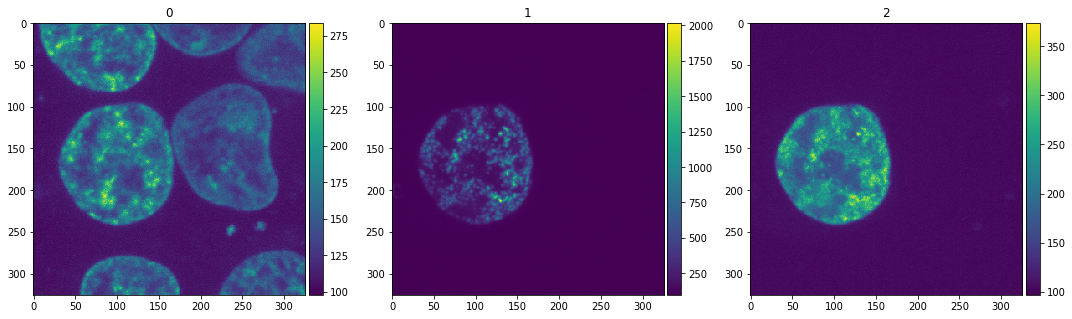

In [6]:
#################################
#  Don't modify the code below  #
#################################

show_dataset(dataset)

### Please select a small box to test the analysis:

Keep the width and height 200 - 500 pixels.

To used the entire image, set x, y, z, width, height and depth to `None`

In [7]:
x = None   # coordinate of the left border
y = None   # coordinate of the top border
z = 0
width = 200   # width of the box
height = 200  # height of the box
depth = 5

### The following code crops the dataset and displays the cropped area:

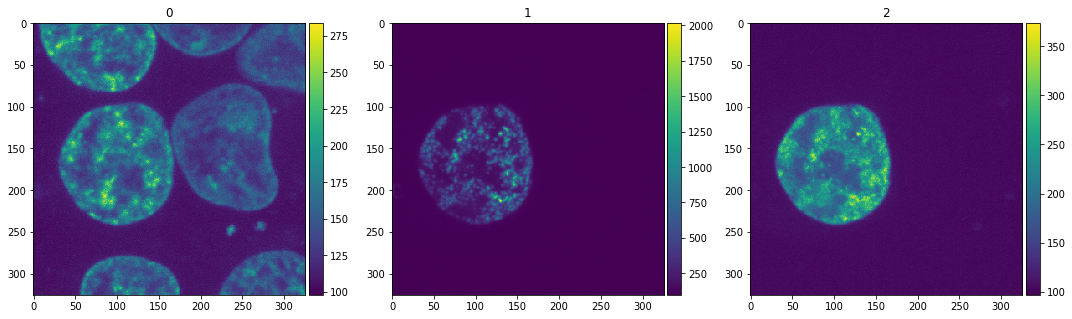

In [8]:
#################################
#  Don't modify the code below  #
#################################

ds_crop = crop_dataset(dataset, x, y, z, width, height, depth)
show_dataset(ds_crop)

### Specify the channel index to segment

Channel index starts from 0.

Cellpose allows using nuclei channel to improve whole-cell segmentation. To use this option, provide two channel indices as a list, where the first index corresponds to the nuclei staining, and the second index corresponds to the cytoplasm staining.

**Examples**: 

`channel = 0`: the first channel will be used to segment ROI (either cells or nuclei)

`channel = [1, 0]`: the second channel (1) will be used as an auxiliary nuclei stain, the first channel (0) will be used to segment whole cells

In [9]:
channel = 0

### Please specify cell segmentation parameters

#### Cellpose parameters

`diameter`: average nucleus diameter in pixels; set to `None` to automatically detect the cell diameter

`model_type`: cellpose model to use for segmentation: ‘nuclei’ for nucleus segmentation, ‘cyto’ or ‘cyto2’ for cell segmentation; we found that ‘cyto’ and ‘cyto2’ models work better than ‘nuclei’ for segmenting nuclei with irregular shapes; for the full list of available models please refer to [cellpose documentation](https://cellpose.readthedocs.io/en/latest/models.html)


#### Postprocessing parameters

`clear_border` : If True, will remove cells touching image border (in xy only).

In [10]:
diameter = None 
model_type = "cyto2" 

clear_border = False

### Advanced parameters:

`flow_threshold`: (cellpose parameter) the maximum allowed error of the flows for each mask; increase if model returns too few masks, decrease if model returns too many ill-shaped masks

`cellprob_threshold`: (cellpose parameter) defines which pixels are used to run dynamics and determine masks; decrease if model returns too few cells, increase if model returns too many cells  
Values should be between -6 and +6

`remove_small_diam_fraction` : size threshold used to exclude small cells/nuclei in the postrocessing; provided as a fraction of the `diameter` parameter. 

`gpu`: set to `True` to use GPU, set to `False` to use CPU

`do_3D`: to perform cellpose segmentation in 3D set to `True`, to segment layer-by-layer set to `False` (the layers will be combined in the postprocessing. Set to `False` to use less memory.


#### Advanced postprocessing parameters

`remove_small_mode` : '2D', or '3D'. Used to remove small cells/nuclei by volume (3D) or area (2D). For a thin stack (as in the example data), use '2D', otherwise, use '3D'.

In [11]:
flow_threshold = 0.4       
cellprob_threshold = 0   
remove_small_diam_fraction = 0.5
gpu = True
do_3D = False

remove_small_mode = '2D'

### The following code segments the random image and displays the results:

2022-06-17 15:58:14,111 [INFO] ** TORCH CUDA version installed and working. **
2022-06-17 15:58:14,112 [INFO] >>>> using GPU
2022-06-17 15:58:14,221 [WARNING] cellprob_threshold and dist_threshold are being deprecated in a future release, use mask_threshold instead
2022-06-17 15:58:14,222 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2022-06-17 15:58:14,223 [INFO] 0%|          | 0/5 [00:00<?, ?it/s]
2022-06-17 15:58:15,015 [WARNING] WARNING: not interp
2022-06-17 15:58:15,346 [INFO] 20%|##        | 1/5 [00:01<00:04,  1.12s/it]
2022-06-17 15:58:16,099 [WARNING] WARNING: not interp
2022-06-17 15:58:16,444 [INFO] 40%|####      | 2/5 [00:02<00:03,  1.11s/it]
2022-06-17 15:58:17,187 [WARNING] WARNING: not interp
2022-06-17 15:58:17,520 [INFO] 60%|######    | 3/5 [00:03<00:02,  1.09s/it]
2022-06-17 15:58:18,268 [WARNING] WARNING: not interp
2022-06-17 15:58:18,601 [INFO] 80%|########  | 4/5 [00:04<00:01,  1.09s/it]
2022-06-17 15:58:19,346 [WARNING] WARNING: not interp
2022-06-17 15:58:19,690 [I

/research/sharedresources/cbi/public/conda_envs/punctatools/lib/python3.9/site-packages/punctatools/lib/segment.py:167: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  flows = np.array([flows[i][0] for i in range(len(flows))])


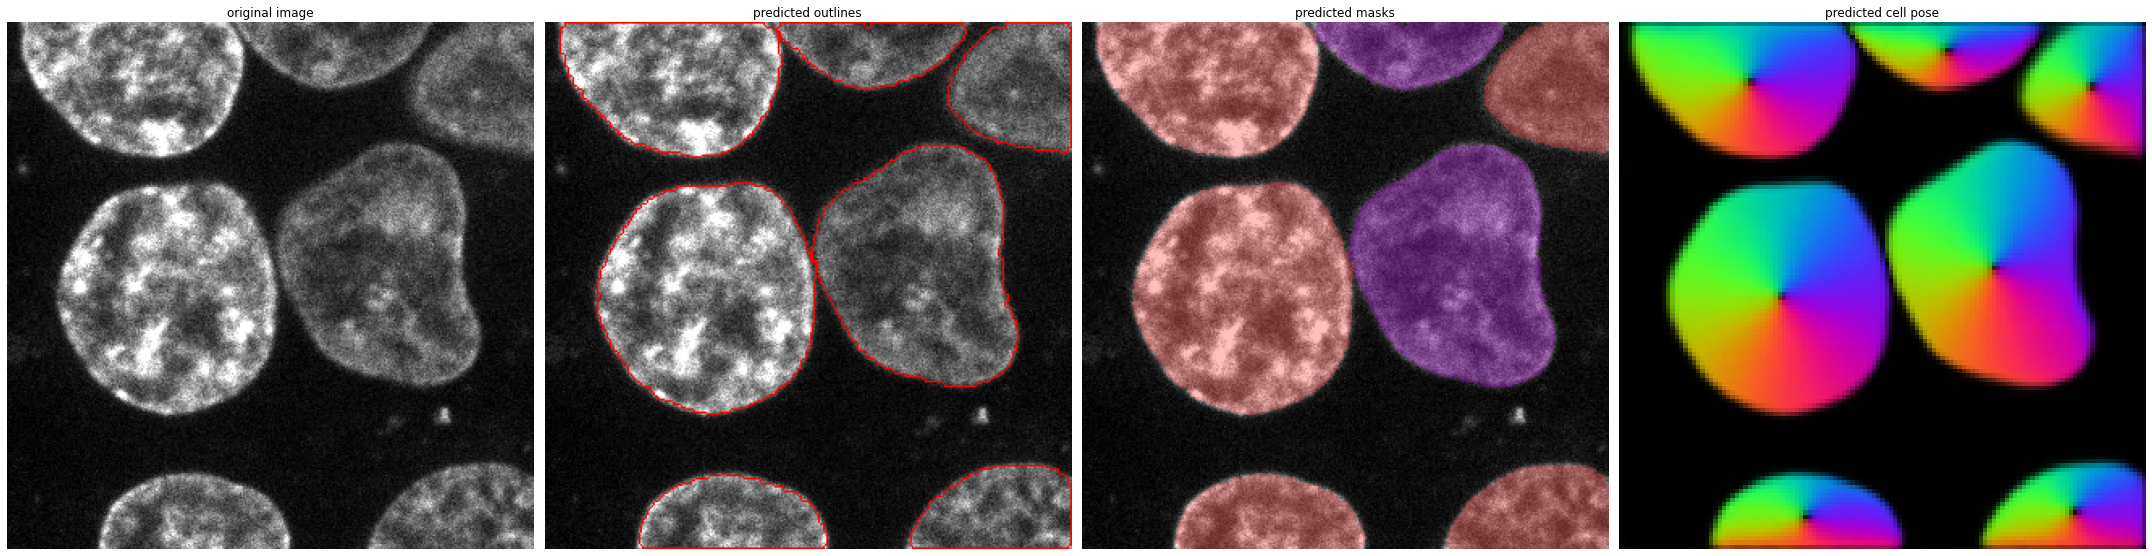

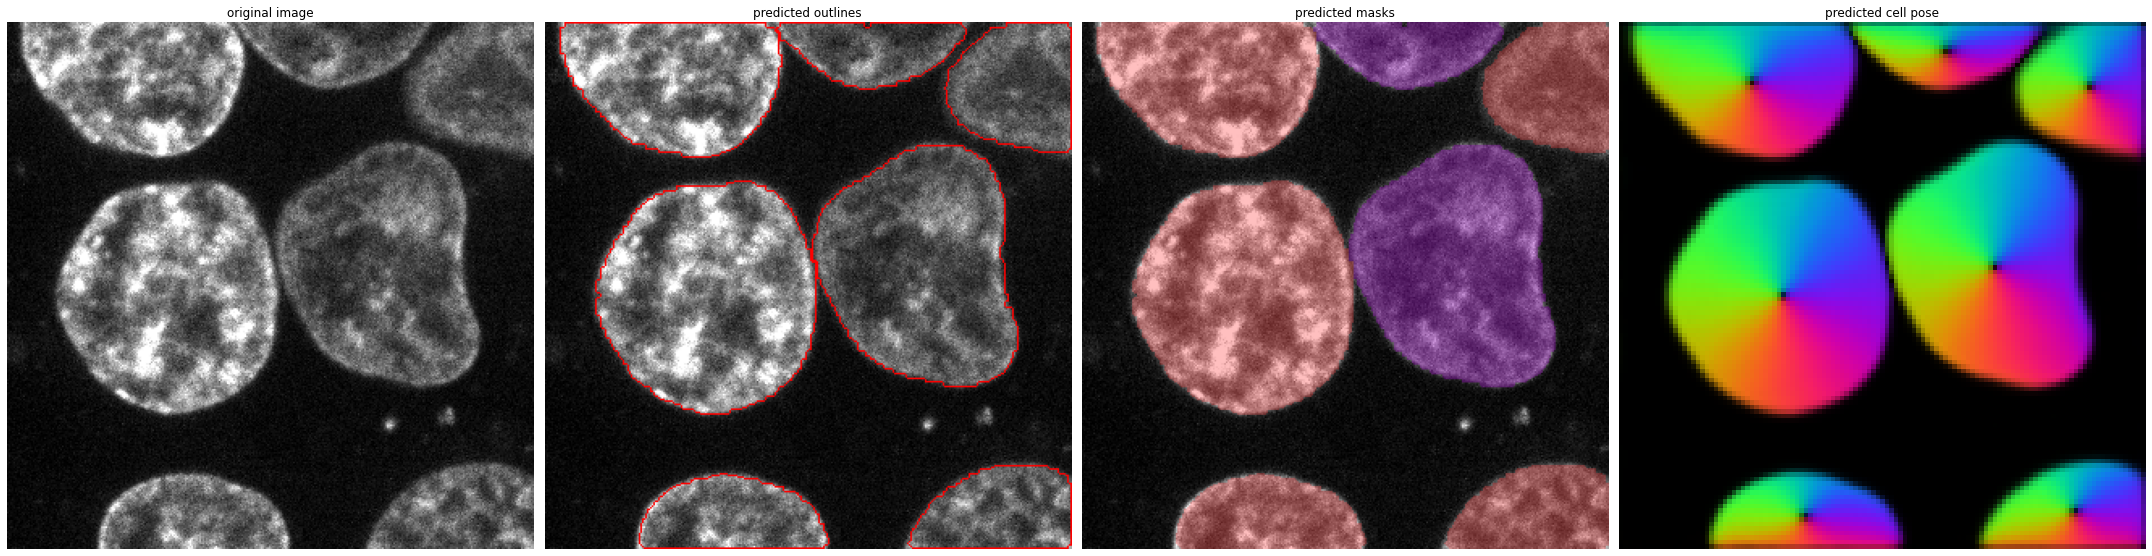

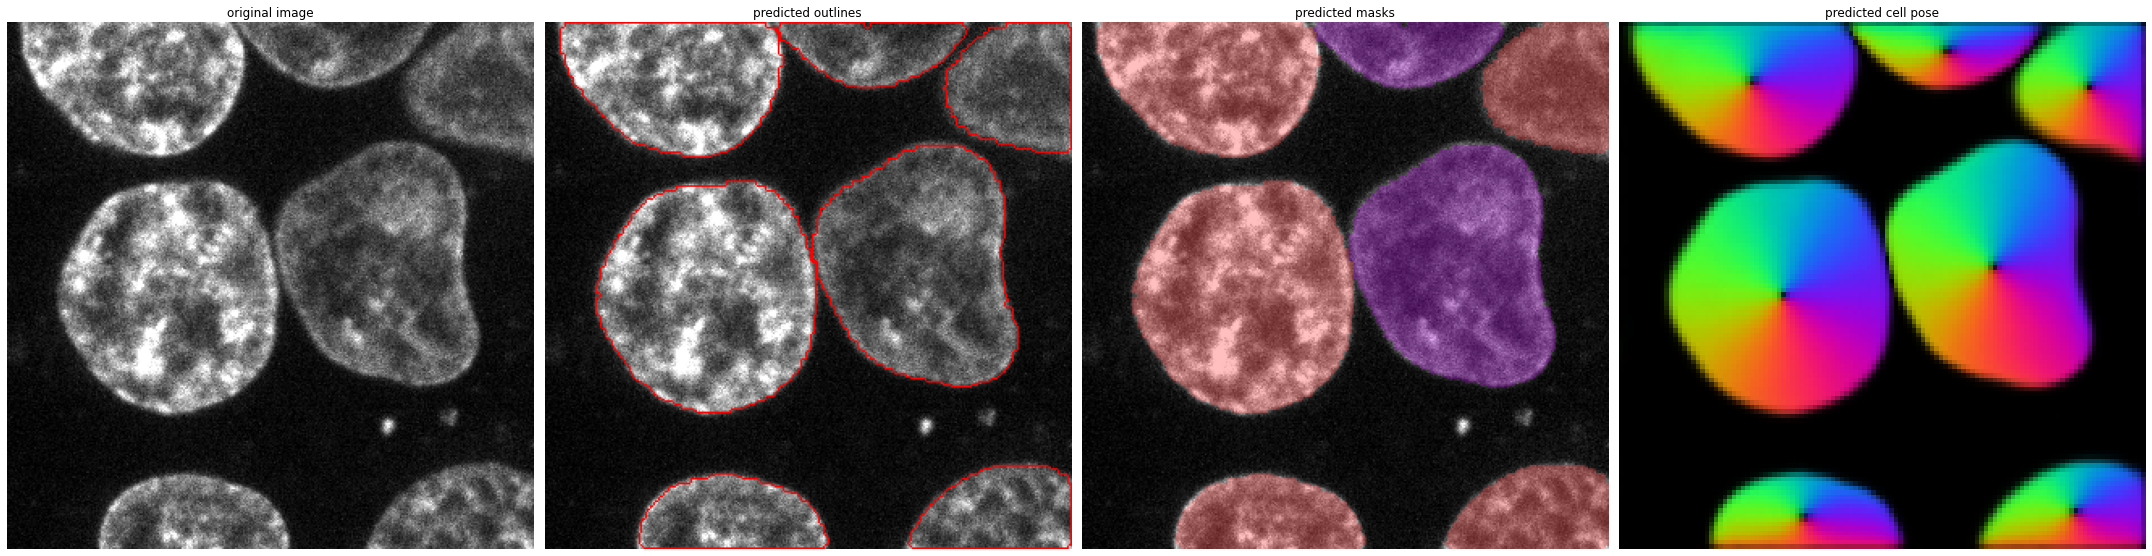

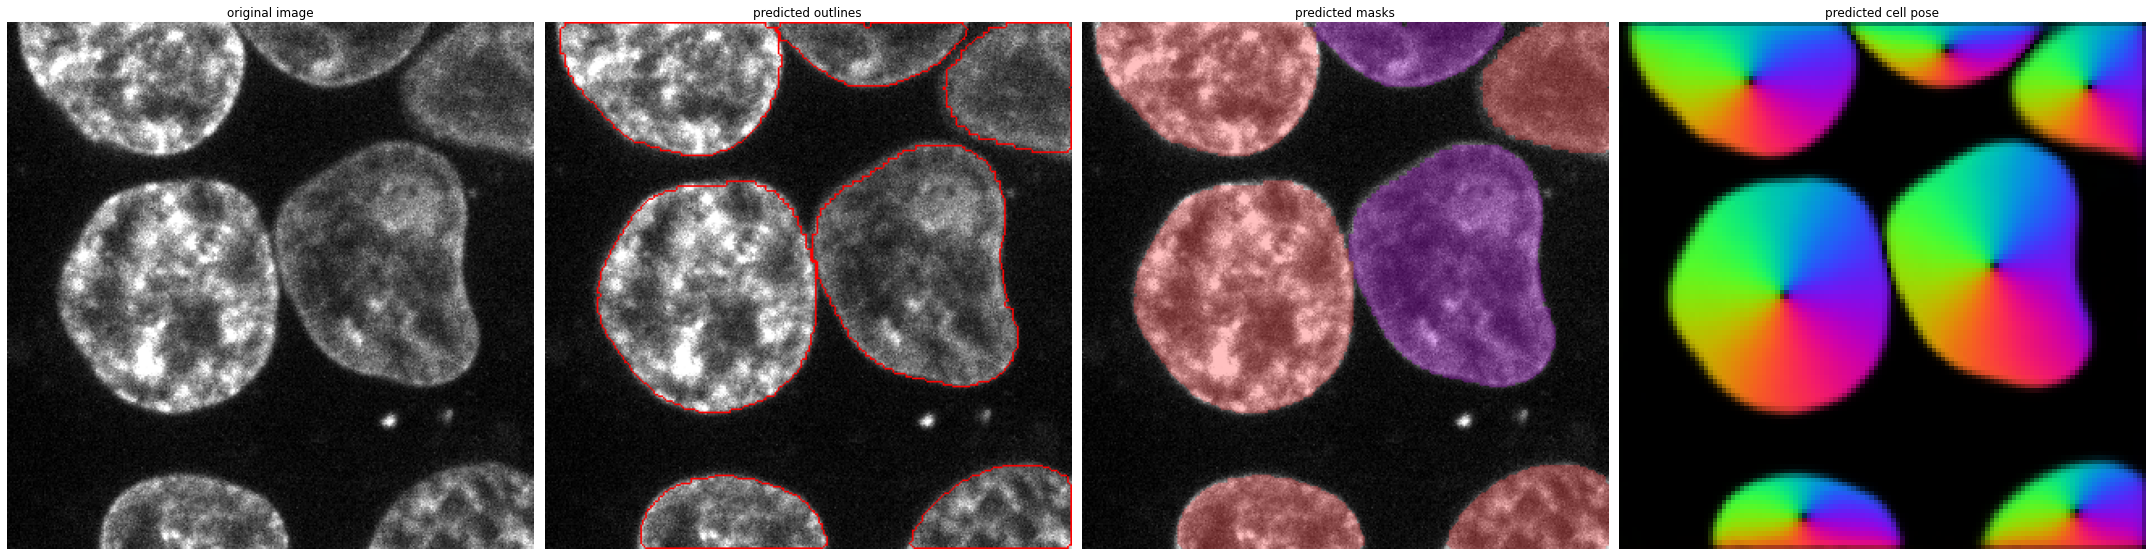

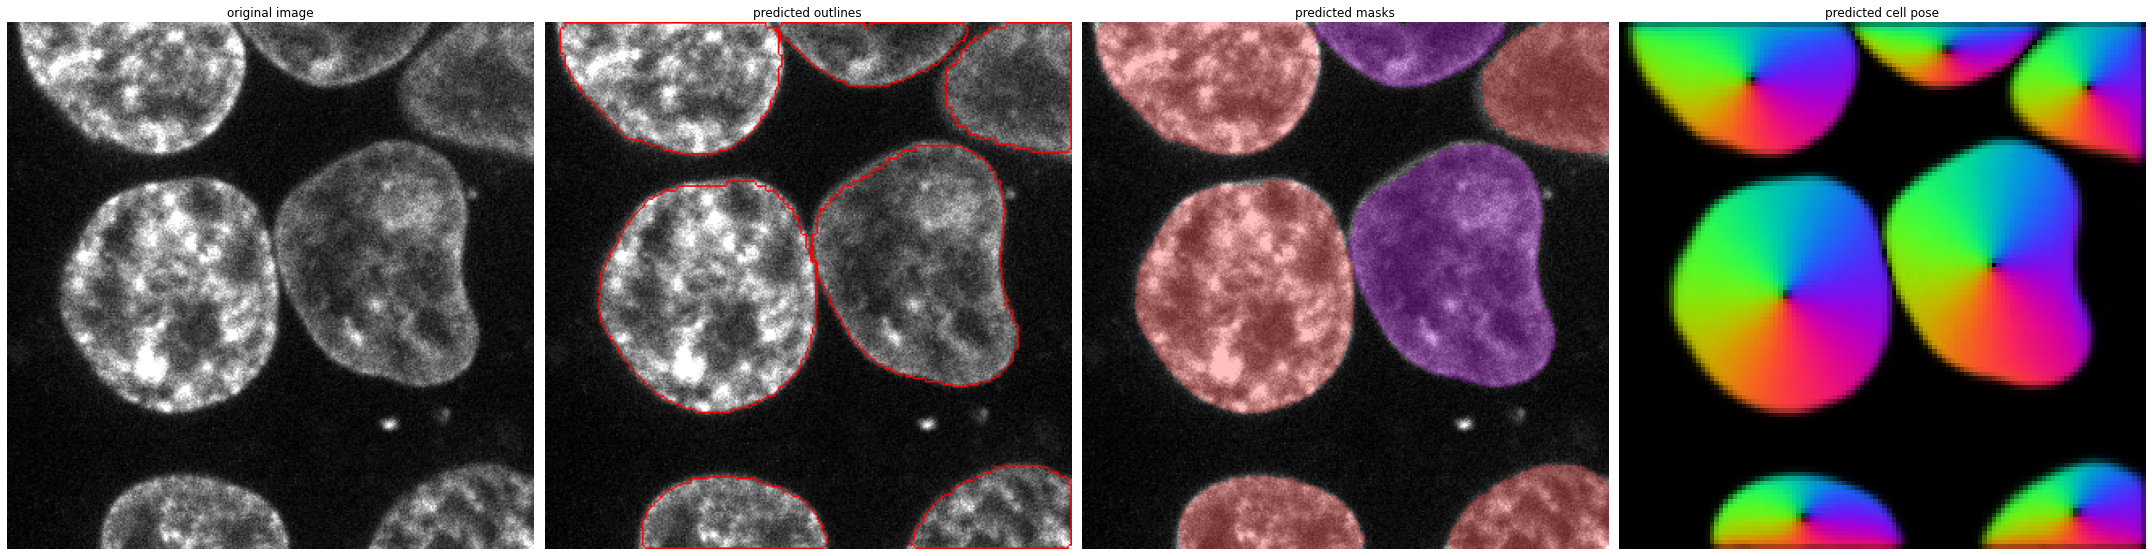

In [12]:
#################################
#  Don't modify the code below  #
#################################

segment_roi(ds_crop, channel, do_3D=do_3D, model_type=model_type,
            diameter=diameter, remove_small_mode=remove_small_mode,
            remove_small_diam_fraction=remove_small_diam_fraction,
            clear_border=clear_border, gpu=gpu,
            flow_threshold=flow_threshold, 
            cellprob_threshold=cellprob_threshold,
            show_cellpose_debug=True);


<hr style="height:2px;">

## Run the full processing

The parameters set up in this notebook will be used to segment images in batch.

<hr style="height:2px;">

### Please provide the file name to save the parameters

If only a filename is provided, the parameter file will be saved in the same directory with this notebook. Provide the full path to save the parameters to a different directory.

Default is `parameters_roi.json`

In [13]:
parameter_file = 'parameters_roi.json'

### The following code saves the parameters

To run the full processing, run the notebook [run_roi_segmentation.ipynb](run_roi_segmentation.ipynb) with the parameter values identified here.

Alternatively run the [run_roi_segmentation.py](../scripts/run_roi_segmentation.py) script:

``python run_roi_segmentation.py -p <parameter_file> -i <input directory> -o <output directory>``

In [ ]:
#################################
#  Don't modify the code below  #
#################################

params = dict(
    input_dir=os.path.realpath(input_dir),
    output_dir=os.path.realpath(output_dir),
    channel=channel,
    diameter=diameter,
    model_type=model_type, 
    do_3D=do_3D,
    remove_small_mode=remove_small_mode,
    remove_small_diam_fraction=remove_small_diam_fraction,
    flow_threshold=flow_threshold,
    cellprob_threshold=cellprob_threshold,
    gpu=gpu
)
with open(parameter_file, 'w') as f:
    json.dump(params, f, indent=4)
    
params